In [1]:
from evaluate_geodiffuser import *

Detectron v2 is not installed


/oscar/scratch/rsajnani/rsajnani/research/2023/GeometryDiffuser/envs/diffusionhandles2/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [15]:

diff_handles = load_diffhandles_model()

exp_path = "/oscar/scratch/rsajnani/rsajnani/research/2023/test_sd/test_sd/prompt-to-prompt/ui_outputs/large_scale_study_all/large_scale_study_dataset_metrics/Translation_3D/14/"


exp_dict = read_exp(exp_path)
# print(exp_dict.keys())
exp_dir_dh = exp_dict["path_name"] + "diffhandles/"
# print(exp_dir_dh)
os.makedirs(exp_dir_dh, exist_ok=True)
# exit()
# print(exp_dict["depth_npy"].shape, exp_dict["depth_npy"].shape)
# exit()


image = exp_dict["input_image_png"] / 255.0
mask = exp_dict["input_mask_png"][..., :1] / 255.0

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

im_removed = remove_foreground(image, mask)
im_removed_np = im_removed.permute(1, 2, 0).detach().cpu().numpy()
im_removed_depth = estimate_depth(im_removed_np)
bg_depth = im_removed_depth

fg_mask = preprocess_image(mask)


# depth = estimate_depth(image)[None]
# im_d = 1 / (im_d + 1e-8)

# save_image((im_d/im_d.max())[0], exp_dir_dh + "im_disparity.png")

# imageio.imwrite(exp_dir_dh + "im_disparity.png", (im_d/im_d.max() * 255.0).astype(np.uint8))
# exit()
depth = preprocess_image(exp_dict["depth_npy"][..., None])
# Normalize depth
depth = depth / (depth.max() + 1e-8) + 1e-2
# making sure that the closest point is far enough from the camera to rotate without causing smearing
# depth = depth
depth[depth > 0.95] = 1.0
bg_depth = bg_depth / (bg_depth.max() + 1e-8) + 1e-2
# depth = 1 / (depth + 1e-2)
bg_depth = diff_handles.set_foreground(depth=depth, fg_mask=fg_mask, bg_depth=(bg_depth[None]))

In [17]:
im_removed_depth_np = bg_depth[0, 0].detach().cpu().numpy()
np.save(exp_dir_dh + "bg_depth_diffhandles.npy", im_removed_depth_np)
im_removed_depth_np_norm = im_removed_depth_np / (im_removed_depth_np.max() + 1e-6)
imageio.imwrite(exp_dir_dh + "im_removed_depth.png", (im_removed_depth_np_norm * 255.0).astype(np.uint8))

# bg_depth = 1 / (bg_depth + 1e-2)

prompt = "a photo of a dog"
img = preprocess_image(image)

null_text_emb, init_noise = diff_handles.invert_input_image(img, depth, prompt)
null_text_emb, init_noise, activations, latent_image = diff_handles.generate_input_image(
            depth=depth, prompt=prompt, null_text_emb=null_text_emb, init_noise=init_noise)


recon_image = latent_to_image(latent_image, diff_handles)
save_image(recon_image.clamp(min=0, max=1)[0], exp_dir_dh + "recon.png")
print("Saved Reconstruction Image for Check")


rot_axis = [0.0, 1.0, 0.0]
rot_angle = 0.0
translation = list(-exp_dict["transform_npy"][:3, -1])

# get transformation parameters
translation = torch.tensor(translation, dtype=torch.float32)
rot_axis = torch.tensor(rot_axis, dtype=torch.float32) 
rot_angle = float(rot_angle) 

results = diff_handles.transform_foreground(
depth=depth, prompt=prompt,
fg_mask=fg_mask, bg_depth=bg_depth,
null_text_emb=null_text_emb, init_noise=init_noise,
activations=activations,
rot_angle=rot_angle, rot_axis=rot_axis, translation=translation,
use_input_depth_normalization=False)

if diff_handles.conf.guided_diffuser.save_denoising_steps:
    edited_img, edited_disparity, denoising_steps = results
else:
    edited_img, edited_disparity = results
    denoising_steps = None

# edited_disparity = 1 / (edited_disparity + 1e-8)

# save_image((edited_disparity/edited_disparity.max())[0], exp_dir_dh + "im_disparity_transformed.png")
# save_image(edited_img[0], exp_dir_dh + "im_edited.png")

DDIM inversion...
Null-text optimization...


100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


Saved Reconstruction Image for Check


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


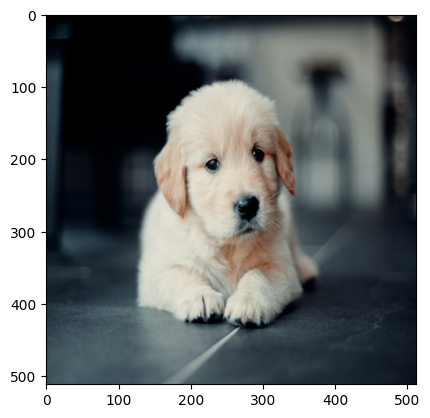

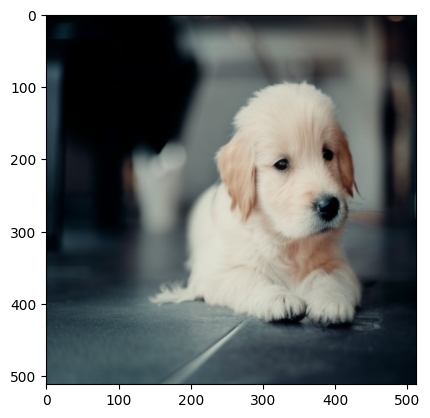

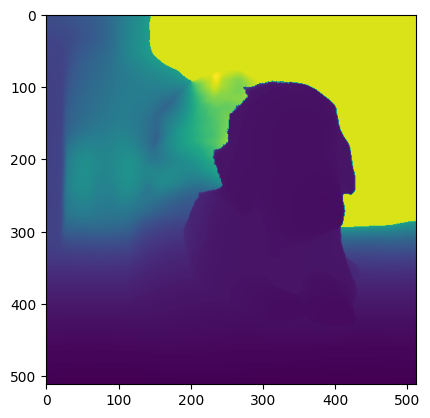

In [18]:
# save_image(edited_img[0], exp_dir_dh + "im_edited.png")
# save_image((edited_disparity/edited_disparity.max())[0], exp_dir_dh + "im_disparity_transformed.png")

# import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import Image
Image('image_path')

plt.imshow(exp_dict["input_image_png"] / 255.0)
plt.show()

plt.imshow(edited_img[0].permute(1, 2, 0).detach().cpu().numpy())
plt.show()


edited_disparity = 1 / (edited_disparity + 1e-2)
edited_disparity = (edited_disparity / edited_disparity.max())
plt.imshow(edited_disparity[0,0].detach().cpu().numpy())
plt.show()


In [19]:
depth_np = estimate_depth(image)[None][0,0].detach().cpu().numpy()

depth_ours_np = preprocess_image(exp_dict["depth_npy"][..., None])[0,0].detach().cpu().numpy()

In [20]:
print(depth_ours_np.shape, depth_np.shape)

print(np.min(depth_np), np.max(depth_np))
print(np.min(depth_ours_np), np.max(depth_ours_np))


depth_np_norm = depth_np / depth_np.max()
depth_ours_np_norm = depth_ours_np / depth_ours_np.max()
print(depth_np_norm - depth_ours_np_norm)


(512, 512) (512, 512)
1.3575169 4.665185
0.0 271.6151
[[-0.19848883 -0.20100772 -0.20135105 ... -0.23756558 -0.23761642
  -0.24019301]
 [-0.19893867 -0.19928974 -0.20056385 ... -0.23682362 -0.2367239
  -0.23718178]
 [-0.19826192 -0.19924569 -0.19992447 ... -0.23595273 -0.23609048
  -0.23622483]
 ...
 [ 0.27114314  0.27292633  0.27319404 ...  0.25697505  0.25682828
   0.25799617]
 [ 0.27793553  0.27272242  0.2778049  ...  0.26034707  0.26174426
   0.2657952 ]
 [ 0.15018348  0.2792337   0.2831031  ...  0.26399553  0.27217367
   0.18390116]]


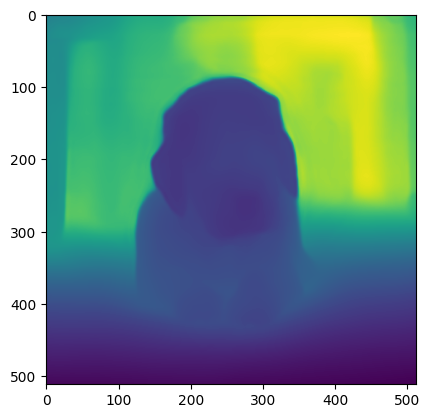

In [21]:
plt.imshow(depth_np_norm)
plt.show()

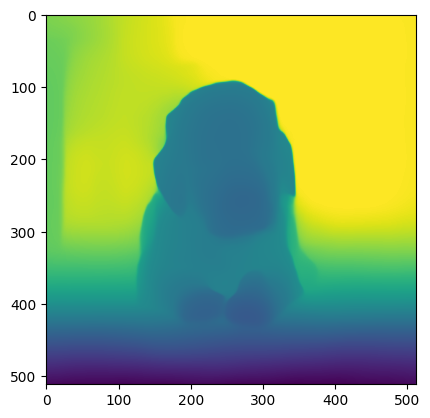

In [22]:
plt.imshow(depth_ours_np_norm)
plt.show()

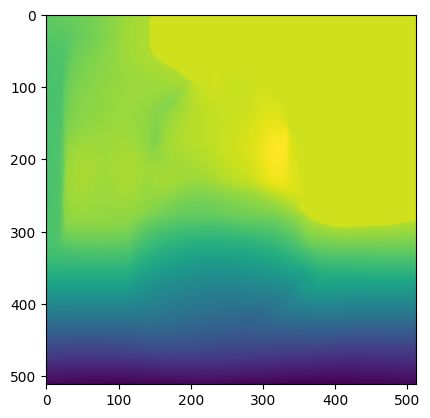

In [23]:
bg_depth_np = bg_depth[0, 0].detach().cpu().numpy()
bg_depth_np_norm = bg_depth_np / bg_depth_np.max()
plt.imshow(bg_depth_np_norm)
plt.show()